In [1]:
import spacy
import gensim
import pandas as pd
import nltk
import numpy as np
import re
import string
import xgboost as xgb

from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from gensim.models.fasttext import FastText
from MeanVectorizer import MeanEmbeddingVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

nltk.download('punkt')
nlp = spacy.blank('id')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\egapa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_excel("dataset_twitter.xlsx")
df.head()

,label,komentar
0,positif,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
1,positif,"Sharing pengalaman aja, kemarin jam 18.00 bata..."
2,positif,Sharing sama temen tuh emg guna bgt. Disaat lu...
3,positif,"sangat bersyukur bisa mendoakan kakeknya, Bung..."
4,positif,H-9. Mau ke bank rame bgt ampe antrian tempat ...


In [3]:
df['label'].value_counts()

negatif    1101
positif    1017
netral      997
Name: label, dtype: int64

negatif    0.353451
positif    0.326485
netral     0.320064
Name: label, dtype: float64

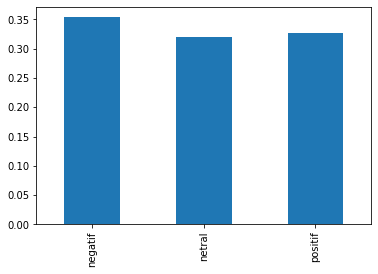

In [4]:
diagram_coba = df.label.value_counts(normalize=True)
diagram_coba[["negatif", "netral", "positif"]].plot(kind="bar")
diagram_coba

In [4]:
komentar = df['komentar'].astype(str)

#Lower case
komentar = komentar.apply(lambda x: x.lower())

#Remove URL
komentar = komentar.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

#Remove Number
komentar = komentar.apply(lambda x: re.sub(r"\d", "", x))

#Before Punctuation
komentar = komentar.apply(lambda x: re.sub(r'(?<=[,.])(?=[^\s])', r' ', x))

#Punctuation
komentar = komentar.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

#Remove Non Alphanumeric
komentar = komentar.apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

#Tokenizing
komentar = komentar.apply(lambda x: nltk.tokenize.word_tokenize(x))

df['komentar'] = komentar
df

,label,komentar
0,positif,"[kepingin, gudeg, mbarek, bu, hj, amad, foto, ..."
1,positif,"[sharing, pengalaman, aja, kemarin, jam, batal..."
2,positif,"[sharing, sama, temen, tuh, emg, guna, bgt, di..."
3,positif,"[sangat, bersyukur, bisa, mendoakan, kakeknya,..."
4,positif,"[h, mau, ke, bank, rame, bgt, ampe, antrian, t..."
...,...,...
3110,netral,"[bukan, saya, yang, tidakmau, merit, sat, ini,..."
3111,netral,"[baru, lihat, kabar, teman, nge, gosip, dan, p..."
3112,netral,"[mengubah, kebiasaan, seseorang, yg, kurang, b..."
3113,netral,"[nah, diam, lebih, bagus, yaudah, saya, diam, ..."


In [5]:
df = df[df.komentar.astype(bool)]

X_temp = df['komentar']
y = df['label']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
model = FastText.load_fasttext_format('../../cc.id.300.bin')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  """Entry point for launching an IPython kernel.


In [8]:
mean_vec_tr = MeanEmbeddingVectorizer(model)

In [9]:
X_train_vector = mean_vec_tr.transform(X_train)
X_test_vector = mean_vec_tr.transform(X_test)

In [10]:
lc=preprocessing.LabelEncoder()
lc.fit(y)

LabelEncoder()

In [11]:
y_train_enc=lc.transform(y_train)
y_test_enc=lc.transform(y_test)

y_train

1498    negatif
1422    negatif
2643     netral
1826    negatif
1699    negatif
         ...   
2847     netral
1669    negatif
2306     netral
326     positif
680     positif
Name: label, Length: 2492, dtype: object

In [12]:
train=xgb.DMatrix(X_train_vector,label=y_train_enc)
test=xgb.DMatrix(X_test_vector,label=y_test_enc)

In [13]:
param = {}

# Learning Rate:  0.01
# Gamma:  0.3
# Max Depth:  7
# Subsample:  0.4
# Colsample Bytree:  0.6
# Alpha:  0
# Lamda:  1.5
# Min Child Weight:  1
# Number of Trees:  1000

param['num_class']=len(set(y))
param['objective'] = 'multi:softmax'
param['learning_rate'] = 0.01
param['gamma'] = 0.3
param['max_depth'] = 7
param['subsample'] = 0.4
param['colsample_bytree'] = 0.6
param['reg_alpha'] = 0
param['reg_lambda'] = 1.5
param['min_child_weight'] = 1
num_round = 1000

watchlist = [(train, 'train'), (test, 'test')]
bst = xgb.train(param, train, num_round, watchlist)

[0]	train-merror:0.34430	test-merror:0.50562
[1]	train-merror:0.26806	test-merror:0.46709
[2]	train-merror:0.21870	test-merror:0.43339
[3]	train-merror:0.19743	test-merror:0.42376
[4]	train-merror:0.17737	test-merror:0.43018
[5]	train-merror:0.15931	test-merror:0.40770
[6]	train-merror:0.15209	test-merror:0.39647
[7]	train-merror:0.13724	test-merror:0.39165
[8]	train-merror:0.13684	test-merror:0.38042
[9]	train-merror:0.12681	test-merror:0.39968
[10]	train-merror:0.12881	test-merror:0.39165
[11]	train-merror:0.12801	test-merror:0.39486
[12]	train-merror:0.12801	test-merror:0.39005
[13]	train-merror:0.11878	test-merror:0.38202
[14]	train-merror:0.11396	test-merror:0.39165
[15]	train-merror:0.11236	test-merror:0.38363
[16]	train-merror:0.11236	test-merror:0.38523
[17]	train-merror:0.10714	test-merror:0.38523
[18]	train-merror:0.10634	test-merror:0.39486
[19]	train-merror:0.10554	test-merror:0.39968
[20]	train-merror:0.10112	test-merror:0.39647
[21]	train-merror:0.10393	test-merror:0.3996

[177]	train-merror:0.03571	test-merror:0.36437
[178]	train-merror:0.03411	test-merror:0.36437
[179]	train-merror:0.03371	test-merror:0.36437
[180]	train-merror:0.03210	test-merror:0.36437
[181]	train-merror:0.03210	test-merror:0.36758
[182]	train-merror:0.03290	test-merror:0.36276
[183]	train-merror:0.03250	test-merror:0.36437
[184]	train-merror:0.03210	test-merror:0.35955
[185]	train-merror:0.03290	test-merror:0.35795
[186]	train-merror:0.03210	test-merror:0.35955
[187]	train-merror:0.03210	test-merror:0.35795
[188]	train-merror:0.03210	test-merror:0.35955
[189]	train-merror:0.03250	test-merror:0.36276
[190]	train-merror:0.03210	test-merror:0.36276
[191]	train-merror:0.03250	test-merror:0.36276
[192]	train-merror:0.03250	test-merror:0.36437
[193]	train-merror:0.03250	test-merror:0.36116
[194]	train-merror:0.03210	test-merror:0.35795
[195]	train-merror:0.03250	test-merror:0.35795
[196]	train-merror:0.03250	test-merror:0.36276
[197]	train-merror:0.03090	test-merror:0.36276
[198]	train-m

[352]	train-merror:0.00883	test-merror:0.35152
[353]	train-merror:0.00843	test-merror:0.35152
[354]	train-merror:0.00803	test-merror:0.34992
[355]	train-merror:0.00803	test-merror:0.35152
[356]	train-merror:0.00843	test-merror:0.34992
[357]	train-merror:0.00843	test-merror:0.35152
[358]	train-merror:0.00843	test-merror:0.35152
[359]	train-merror:0.00843	test-merror:0.34992
[360]	train-merror:0.00843	test-merror:0.34831
[361]	train-merror:0.00843	test-merror:0.34992
[362]	train-merror:0.00803	test-merror:0.34992
[363]	train-merror:0.00762	test-merror:0.35152
[364]	train-merror:0.00762	test-merror:0.34831
[365]	train-merror:0.00762	test-merror:0.34671
[366]	train-merror:0.00762	test-merror:0.34671
[367]	train-merror:0.00803	test-merror:0.34671
[368]	train-merror:0.00762	test-merror:0.34831
[369]	train-merror:0.00803	test-merror:0.34831
[370]	train-merror:0.00762	test-merror:0.34831
[371]	train-merror:0.00762	test-merror:0.34831
[372]	train-merror:0.00762	test-merror:0.34831
[373]	train-m

[527]	train-merror:0.00361	test-merror:0.33387
[528]	train-merror:0.00361	test-merror:0.33387
[529]	train-merror:0.00361	test-merror:0.33387
[530]	train-merror:0.00361	test-merror:0.33387
[531]	train-merror:0.00361	test-merror:0.33387
[532]	train-merror:0.00361	test-merror:0.33387
[533]	train-merror:0.00361	test-merror:0.33708
[534]	train-merror:0.00361	test-merror:0.33868
[535]	train-merror:0.00361	test-merror:0.34029
[536]	train-merror:0.00361	test-merror:0.34029
[537]	train-merror:0.00361	test-merror:0.33708
[538]	train-merror:0.00361	test-merror:0.33868
[539]	train-merror:0.00361	test-merror:0.33547
[540]	train-merror:0.00361	test-merror:0.33708
[541]	train-merror:0.00361	test-merror:0.33547
[542]	train-merror:0.00361	test-merror:0.33387
[543]	train-merror:0.00361	test-merror:0.33226
[544]	train-merror:0.00361	test-merror:0.33226
[545]	train-merror:0.00361	test-merror:0.33387
[546]	train-merror:0.00361	test-merror:0.33226
[547]	train-merror:0.00361	test-merror:0.33226
[548]	train-m

[702]	train-merror:0.00120	test-merror:0.32905
[703]	train-merror:0.00120	test-merror:0.32745
[704]	train-merror:0.00120	test-merror:0.32905
[705]	train-merror:0.00120	test-merror:0.32905
[706]	train-merror:0.00120	test-merror:0.32905
[707]	train-merror:0.00120	test-merror:0.32905
[708]	train-merror:0.00120	test-merror:0.32745
[709]	train-merror:0.00120	test-merror:0.32745
[710]	train-merror:0.00120	test-merror:0.32745
[711]	train-merror:0.00120	test-merror:0.32905
[712]	train-merror:0.00120	test-merror:0.32905
[713]	train-merror:0.00120	test-merror:0.32905
[714]	train-merror:0.00120	test-merror:0.32905
[715]	train-merror:0.00120	test-merror:0.33066
[716]	train-merror:0.00120	test-merror:0.33066
[717]	train-merror:0.00120	test-merror:0.33226
[718]	train-merror:0.00120	test-merror:0.33226
[719]	train-merror:0.00120	test-merror:0.33387
[720]	train-merror:0.00120	test-merror:0.33226
[721]	train-merror:0.00120	test-merror:0.33066
[722]	train-merror:0.00120	test-merror:0.33066
[723]	train-m

[877]	train-merror:0.00040	test-merror:0.32584
[878]	train-merror:0.00040	test-merror:0.32584
[879]	train-merror:0.00040	test-merror:0.32584
[880]	train-merror:0.00040	test-merror:0.32584
[881]	train-merror:0.00040	test-merror:0.32584
[882]	train-merror:0.00040	test-merror:0.32584
[883]	train-merror:0.00040	test-merror:0.32584
[884]	train-merror:0.00040	test-merror:0.32424
[885]	train-merror:0.00040	test-merror:0.32584
[886]	train-merror:0.00040	test-merror:0.32584
[887]	train-merror:0.00040	test-merror:0.32584
[888]	train-merror:0.00040	test-merror:0.32584
[889]	train-merror:0.00040	test-merror:0.32584
[890]	train-merror:0.00040	test-merror:0.32584
[891]	train-merror:0.00040	test-merror:0.32584
[892]	train-merror:0.00040	test-merror:0.32584
[893]	train-merror:0.00040	test-merror:0.32584
[894]	train-merror:0.00040	test-merror:0.32584
[895]	train-merror:0.00040	test-merror:0.32584
[896]	train-merror:0.00040	test-merror:0.32424
[897]	train-merror:0.00040	test-merror:0.32424
[898]	train-m

In [20]:
pred = bst.predict(test)
pred2 = bst.predict(train)

array([0., 2., 0., 2., 1., 0., 1., 2., 2., 0., 0., 1., 1., 1., 0., 1., 2.,
       1., 0., 0., 2., 0., 1., 0., 0., 1., 2., 0., 0., 1., 1., 2., 0., 1.,
       1., 0., 2., 2., 0., 0., 0., 0., 2., 0., 2., 0., 2., 1., 2., 1., 1.,
       1., 1., 1., 2., 0., 0., 1., 1., 0., 0., 1., 2., 0., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 2., 2., 0., 1., 1., 0., 2., 2., 1., 1., 2.,
       0., 2., 0., 2., 0., 2., 0., 1., 2., 0., 0., 0., 0., 1., 2., 0., 2.,
       2., 1., 1., 0., 1., 2., 2., 2., 2., 2., 1., 1., 2., 2., 1., 1., 0.,
       2., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 2., 1.,
       0., 2., 1., 0., 0., 0., 2., 1., 2., 2., 2., 1., 0., 0., 0., 0., 0.,
       2., 2., 0., 1., 0., 2., 1., 1., 1., 1., 2., 0., 1., 2., 0., 1., 1.,
       0., 1., 2., 0., 2., 1., 0., 0., 2., 0., 1., 0., 2., 1., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0., 1., 1., 2., 2.,
       2., 2., 2., 0., 2., 0., 1., 2., 1., 2., 1., 0., 2., 0., 1., 2., 0.,
       1., 1., 2., 2., 0.

In [19]:
predictions = lc.inverse_transform(list(map(int,pred)))
predictions2 = lc.inverse_transform(list(map(int,pred2)))

array(['negatif', 'positif', 'negatif', 'positif', 'netral', 'negatif',
       'netral', 'positif', 'positif', 'negatif', 'negatif', 'netral',
       'netral', 'netral', 'negatif', 'netral', 'positif', 'netral',
       'negatif', 'negatif', 'positif', 'negatif', 'netral', 'negatif',
       'negatif', 'netral', 'positif', 'negatif', 'negatif', 'netral',
       'netral', 'positif', 'negatif', 'netral', 'netral', 'negatif',
       'positif', 'positif', 'negatif', 'negatif', 'negatif', 'negatif',
       'positif', 'negatif', 'positif', 'negatif', 'positif', 'netral',
       'positif', 'netral', 'netral', 'netral', 'netral', 'netral',
       'positif', 'negatif', 'negatif', 'netral', 'netral', 'negatif',
       'negatif', 'netral', 'positif', 'negatif', 'netral', 'negatif',
       'negatif', 'negatif', 'netral', 'netral', 'negatif', 'negatif',
       'negatif', 'negatif', 'positif', 'positif', 'negatif', 'netral',
       'netral', 'negatif', 'positif', 'positif', 'netral', 'netral',
       

In [16]:
test_score = accuracy_score(predictions,y_test)
train_score = accuracy_score(predictions2, y_train)

print("\nTest Score\n", test_score, "\n")
print("Train Score\n", train_score, "\n")
print("CONFUSSION MATRIX\n", confusion_matrix(y_test, predictions), "\n")
print("CLASSIFICATION REPORT\n", classification_report(y_test, predictions), "\n")


Test Score
 0.6741573033707865 

Train Score
 0.9995987158908507 

CONFUSSION MATRIX
 [[174  30  16]
 [ 39 117  44]
 [ 25  49 129]] 

CLASSIFICATION REPORT
               precision    recall  f1-score   support

     negatif       0.73      0.79      0.76       220
      netral       0.60      0.58      0.59       200
     positif       0.68      0.64      0.66       203

    accuracy                           0.67       623
   macro avg       0.67      0.67      0.67       623
weighted avg       0.67      0.67      0.67       623
 



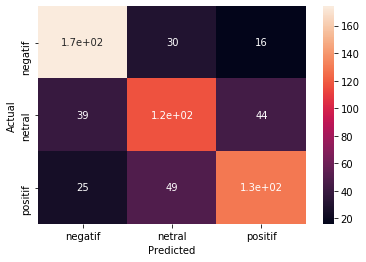

In [17]:
import seaborn as sn

confusion = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion, annot=True)

In [18]:
# # Create XGB Classifier object
# xgb_clf = xgb.XGBClassifier(tree_method = "exact", predictor = "gpu_predictor", verbosity = 1, objective = "multi:softmax")

# # Create parameter grid
# # parameters = {"learning_rate": [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.001],
# #                "gamma" : [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1, 1.5, 2, 3, 4, 6],
# #                "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20],
# #                "colsample_bytree": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
# #                "subsample": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
# #                "reg_alpha": [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
# #                "reg_lambda": [1, 1.5, 2, 3, 4.5, 4, 5],
# #                "min_child_weight": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
# #                "n_estimators": [100, 250, 500, 1000],
# #                "num_boost_round": [100, 250, 500, 750, 1000]}

# parameters = {"learning_rate": [0.1, 0.01, 0.001],
#                "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
#                "max_depth": [2, 4, 7, 10],
#                "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
#                "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
#                "reg_alpha": [0, 0.5, 1],
#                "reg_lambda": [1, 1.5, 2, 3, 4.5],
#                "min_child_weight": [1, 3, 5, 7],
#                "n_estimators": [100, 250, 500, 1000]}

# from sklearn.model_selection import RandomizedSearchCV
# # Create RandomizedSearchCV Object
# xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "f1_micro",
#                              cv = 10, verbose = 3, random_state = 40 )
           
# # Fit the model
# model_xgboost = xgb_rscv.fit(X_train_vector, y_train)

# # Model best estimators
# print("Learning Rate: ", model_xgboost.best_estimator_.get_params()["learning_rate"])
# print("Gamma: ", model_xgboost.best_estimator_.get_params()["gamma"])
# print("Max Depth: ", model_xgboost.best_estimator_.get_params()["max_depth"])
# print("Subsample: ", model_xgboost.best_estimator_.get_params()["subsample"])
# print("Colsample Bytree: ", model_xgboost.best_estimator_.get_params()["colsample_bytree"])
# print("Alpha: ", model_xgboost.best_estimator_.get_params()["reg_alpha"])
# print("Lamda: ", model_xgboost.best_estimator_.get_params()["reg_lambda"])
# print("Min Child Weight: ", model_xgboost.best_estimator_.get_params()["min_child_weight"])
# print("Number of Trees: ", model_xgboost.best_estimator_.get_params()["n_estimators"])